In [2]:
!pip install download

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/python-3.7.10/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/dataset_pix2pix.tar"

download(url, "./dataset", kind="tar", replace=True)


file_sizes: 100%|█████████████████████████████| 881M/881M [00:04<00:00, 185MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

In [4]:
# %%capture captured_output

# !pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.2.14/MindSpore/unified/x86_64/mindspore-2.2.14-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple
# !wget https://mindspore-demo.obs.cn-north-4.myhuaweicloud.com/mindnlp_install/mindnlp-0.3.1-py3-none-any.whl
# !pip install mindnlp-0.3.1-py3-none-any.whl
# !pip install gradio mdtex2html -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install ipywidgets -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install PyPDF2==3.0.1 markdown==3.6 beautifulsoup4==4.12.3 sentence_transformers

!pip install mindspore

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 742.8 MB 84.4 MB/s eta 0:00:01    |████▏                           | 97.4 MB 87.4 MB/s eta 0:00:08     |██████                          | 138.2 MB 87.4 MB/s eta 0:00:07     |███████████████████████▊        | 551.5 MB 88.7 MB/s eta 0:00:03     |█████████████████████████████▊  | 690.1 MB 92.3 MB/s eta 0:00:01     |███████████████████████████████ | 717.3 MB 84.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/python-3.7.10/bin/python3.7 -m pip install --upgrade pip' command.


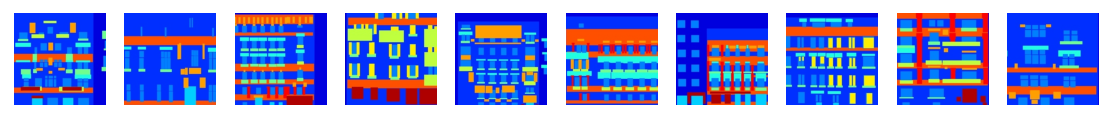

In [5]:
from mindspore import dataset as ds
import matplotlib.pyplot as plt

dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator(output_numpy=True))
# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['input_images'][:10], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow((image.transpose(1, 2, 0) + 1) / 2)
plt.show()

#### 定义UNet Skip Connection Block

In [6]:
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops

class UNetSkipConnectionBlock(nn.Cell):
    def __init__(self, outer_nc, inner_nc, in_planes=None, dropout=False,
                 submodule=None, outermost=False, innermost=False, alpha=0.2, norm_mode='batch'):
        super(UNetSkipConnectionBlock, self).__init__()
        down_norm = nn.BatchNorm2d(inner_nc)
        up_norm = nn.BatchNorm2d(outer_nc)
        use_bias = False
        if norm_mode == 'instance':
            down_norm = nn.BatchNorm2d(inner_nc, affine=False)
            up_norm = nn.BatchNorm2d(outer_nc, affine=False)
            use_bias = True
        if in_planes is None:
            in_planes = outer_nc
        down_conv = nn.Conv2d(in_planes, inner_nc, kernel_size=4,
                              stride=2, padding=1, has_bias=use_bias, pad_mode='pad')
        down_relu = nn.LeakyReLU(alpha)
        up_relu = nn.ReLU()
        if outermost:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, pad_mode='pad')
            down = [down_conv]
            up = [up_relu, up_conv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            up_conv = nn.Conv2dTranspose(inner_nc, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv]
            up = [up_relu, up_conv, up_norm]
            model = down + up
        else:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv, down_norm]
            up = [up_relu, up_conv, up_norm]

            model = down + [submodule] + up
            if dropout:
                model.append(nn.Dropout(p=0.5))
        self.model = nn.SequentialCell(model)
        self.skip_connections = not outermost

    def construct(self, x):
        out = self.model(x)
        if self.skip_connections:
            out = ops.concat((out, x), axis=1)
        return out

#### 基于UNet的生成器

In [7]:
class UNetGenerator(nn.Cell):
    def __init__(self, in_planes, out_planes, ngf=64, n_layers=8, norm_mode='bn', dropout=False):
        super(UNetGenerator, self).__init__()
        unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=None,
                                             norm_mode=norm_mode, innermost=True)
        for _ in range(n_layers - 5):
            unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=unet_block,
                                                 norm_mode=norm_mode, dropout=dropout)
        unet_block = UNetSkipConnectionBlock(ngf * 4, ngf * 8, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf * 2, ngf * 4, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf, ngf * 2, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        self.model = UNetSkipConnectionBlock(out_planes, ngf, in_planes=in_planes, submodule=unet_block,
                                             outermost=True, norm_mode=norm_mode)

    def construct(self, x):
        return self.model(x)

原始cGAN的输入是条件x和噪声z两种信息，这里的生成器只使用了条件信息，因此不能生成多样性的结果。因此Pix2Pix在训练和测试时都使用了dropout，这样可以生成多样性的结果。

### 基于PatchGAN的判别器

判别器使用的PatchGAN结构，可看做卷积。生成的矩阵中的每个点代表原图的一小块区域（patch）。通过矩阵中的各个值来判断原图中对应每个Patch的真假。

In [8]:
import mindspore.nn as nn

class ConvNormRelu(nn.Cell):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvNormRelu, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if not padding:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad',
                             has_bias=has_bias, padding=padding)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad', has_bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

class Discriminator(nn.Cell):
    def __init__(self, in_planes=3, ndf=64, n_layers=3, alpha=0.2, norm_mode='batch'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [
            nn.Conv2d(in_planes, ndf, kernel_size, 2, pad_mode='pad', padding=1),
            nn.LeakyReLU(alpha)
        ]
        nf_mult = ndf
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * ndf
            layers.append(ConvNormRelu(nf_mult_prev, nf_mult, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * ndf
        layers.append(ConvNormRelu(nf_mult_prev, nf_mult, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1))
        self.features = nn.SequentialCell(layers)

    def construct(self, x, y):
        x_y = ops.concat((x, y), axis=1)
        output = self.features(x_y)
        return output

### Pix2Pix的生成器和判别器初始化

实例化Pix2Pix生成器和判别器。

In [9]:
import mindspore.nn as nn
from mindspore.common import initializer as init

g_in_planes = 3
g_out_planes = 3
g_ngf = 64
g_layers = 8
d_in_planes = 6
d_ndf = 64
d_layers = 3
alpha = 0.2
init_gain = 0.02
init_type = 'normal'


net_generator = UNetGenerator(in_planes=g_in_planes, out_planes=g_out_planes,
                              ngf=g_ngf, n_layers=g_layers)
for _, cell in net_generator.cells_and_names():
    if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
        if init_type == 'normal':
            cell.weight.set_data(init.initializer(init.Normal(init_gain), cell.weight.shape))
        elif init_type == 'xavier':
            cell.weight.set_data(init.initializer(init.XavierUniform(init_gain), cell.weight.shape))
        elif init_type == 'constant':
            cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
    elif isinstance(cell, nn.BatchNorm2d):
        cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
        cell.beta.set_data(init.initializer('zeros', cell.beta.shape))


net_discriminator = Discriminator(in_planes=d_in_planes, ndf=d_ndf,
                                  alpha=alpha, n_layers=d_layers)
for _, cell in net_discriminator.cells_and_names():
    if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
        if init_type == 'normal':
            cell.weight.set_data(init.initializer(init.Normal(init_gain), cell.weight.shape))
        elif init_type == 'xavier':
            cell.weight.set_data(init.initializer(init.XavierUniform(init_gain), cell.weight.shape))
        elif init_type == 'constant':
            cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
    elif isinstance(cell, nn.BatchNorm2d):
        cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
        cell.beta.set_data(init.initializer('zeros', cell.beta.shape))

class Pix2Pix(nn.Cell):
    """Pix2Pix模型网络"""
    def __init__(self, discriminator, generator):
        super(Pix2Pix, self).__init__(auto_prefix=True)
        self.net_discriminator = discriminator
        self.net_generator = generator

    def construct(self, reala):
        fakeb = self.net_generator(reala)
        return fakeb

## 训练

训练分为两个主要部分：训练判别器和训练生成器。训练判别器的目的是最大程度地提高判别图像真伪的概率。训练生成器是希望能产生更好的虚假图像。在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计。在训练过程加上对图形色彩信息的捕捉，增强线框生成。

下面进行训练：

In [10]:
import numpy as np
import os
import datetime
from mindspore import value_and_grad, Tensor

epoch_num = 1
ckpt_dir = "results/ckpt"
dataset_size = 400
val_pic_size = 256
lr = 0.0002
n_epochs = 1000
n_epochs_decay = 100

def get_lr():
    lrs = [lr] * dataset_size * n_epochs
    lr_epoch = 0
    for epoch in range(n_epochs_decay):
        lr_epoch = lr * (n_epochs_decay - epoch) / n_epochs_decay
        lrs += [lr_epoch] * dataset_size
    lrs += [lr_epoch] * dataset_size * (epoch_num - n_epochs_decay - n_epochs)
    return Tensor(np.array(lrs).astype(np.float32))

dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True, num_parallel_workers=8)
steps_per_epoch = dataset.get_dataset_size()
loss_f = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

def forword_dis(reala, realb):
    lambda_dis = 0.5
    fakeb = net_generator(reala)
    pred0 = net_discriminator(reala, fakeb)
    pred1 = net_discriminator(reala, realb)
    loss_d = loss_f(pred1, ops.ones_like(pred1)) + loss_f(pred0, ops.zeros_like(pred0))
    loss_dis = loss_d * lambda_dis
    return loss_dis

def forword_gan(reala, realb):
    lambda_gan = 0.5
    lambda_l1 = 100
    fakeb = net_generator(reala)
    pred0 = net_discriminator(reala, fakeb)
    loss_1 = loss_f(pred0, ops.ones_like(pred0))
    loss_2 = l1_loss(fakeb, realb)
    loss_gan = loss_1 * lambda_gan + loss_2 * lambda_l1
    return loss_gan

d_opt = nn.Adam(net_discriminator.trainable_params(), learning_rate=get_lr(),
                beta1=0.5, beta2=0.999, loss_scale=1)
g_opt = nn.Adam(net_generator.trainable_params(), learning_rate=get_lr(),
                beta1=0.5, beta2=0.999, loss_scale=1)

grad_d = value_and_grad(forword_dis, None, net_discriminator.trainable_params())
grad_g = value_and_grad(forword_gan, None, net_generator.trainable_params())

def train_step(reala, realb):
    loss_dis, d_grads = grad_d(reala, realb)
    loss_gan, g_grads = grad_g(reala, realb)
    d_opt(d_grads)
    g_opt(g_grads)
    return loss_dis, loss_gan

if not os.path.isdir(ckpt_dir):
    os.makedirs(ckpt_dir)

g_losses = []
d_losses = []
data_loader = dataset.create_dict_iterator(output_numpy=True, num_epochs=epoch_num)

for epoch in range(epoch_num):
    for i, data in enumerate(data_loader):
        start_time = datetime.datetime.now()
        input_image = Tensor(data["input_images"])
        target_image = Tensor(data["target_images"])
        dis_loss, gen_loss = train_step(input_image, target_image)
        end_time = datetime.datetime.now()
        delta = (end_time - start_time).microseconds
        if i % 2 == 0:
            print("ms per step:{:.2f}  epoch:{}/{}  step:{}/{}  Dloss:{:.4f}  Gloss:{:.4f} ".format((delta / 1000), (epoch + 1), (epoch_num), i, steps_per_epoch, float(dis_loss), float(gen_loss)))
        d_losses.append(dis_loss.asnumpy())
        g_losses.append(gen_loss.asnumpy())
    if (epoch + 1) == epoch_num:
        mindspore.save_checkpoint(net_generator, ckpt_dir + "4Generator.ckpt")

ms per step:548.41  epoch:1/1  step:0/25  Dloss:0.6937  Gloss:38.6809 
ms per step:492.34  epoch:1/1  step:2/25  Dloss:0.6518  Gloss:37.6611 
ms per step:493.64  epoch:1/1  step:4/25  Dloss:0.5485  Gloss:38.8498 
ms per step:496.84  epoch:1/1  step:6/25  Dloss:0.6515  Gloss:36.2618 
ms per step:511.32  epoch:1/1  step:8/25  Dloss:0.4937  Gloss:37.3895 
ms per step:511.48  epoch:1/1  step:10/25  Dloss:0.3171  Gloss:37.3668 
ms per step:516.16  epoch:1/1  step:12/25  Dloss:0.4574  Gloss:36.3697 
ms per step:510.85  epoch:1/1  step:14/25  Dloss:0.3967  Gloss:32.0409 
ms per step:515.07  epoch:1/1  step:16/25  Dloss:0.2331  Gloss:35.0009 
ms per step:513.98  epoch:1/1  step:18/25  Dloss:1.2139  Gloss:42.1760 
ms per step:511.61  epoch:1/1  step:20/25  Dloss:0.4530  Gloss:34.0744 
ms per step:511.99  epoch:1/1  step:22/25  Dloss:0.2890  Gloss:39.7147 
ms per step:510.15  epoch:1/1  step:24/25  Dloss:0.2839  Gloss:35.6331 


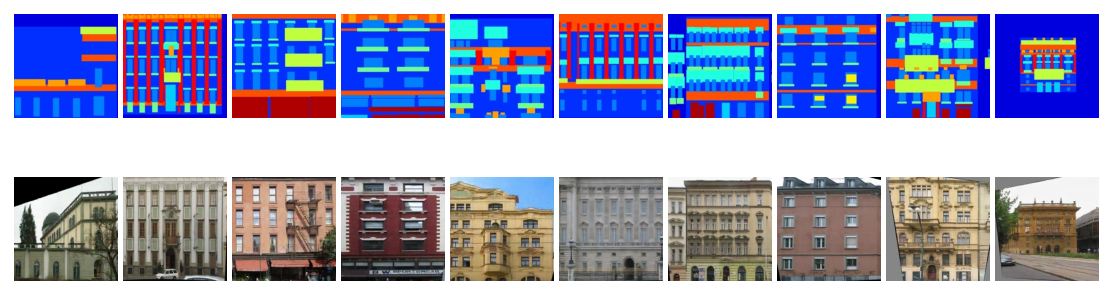

In [11]:
from mindspore import load_checkpoint, load_param_into_net

param_g = load_checkpoint( "ckpt2Generator.ckpt")
load_param_into_net(net_generator, param_g)
dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator())
predict_show = net_generator(data_iter["input_images"])
plt.figure(figsize=(10, 3), dpi=140)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow((data_iter["input_images"][i].asnumpy().transpose(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.subplot(2, 10, i + 11)
    plt.imshow((predict_show[i].asnumpy().transpose(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.show()


各数据集分别推理的效果如下

![pix2pix3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/generative/images/pix2pix_3.png)

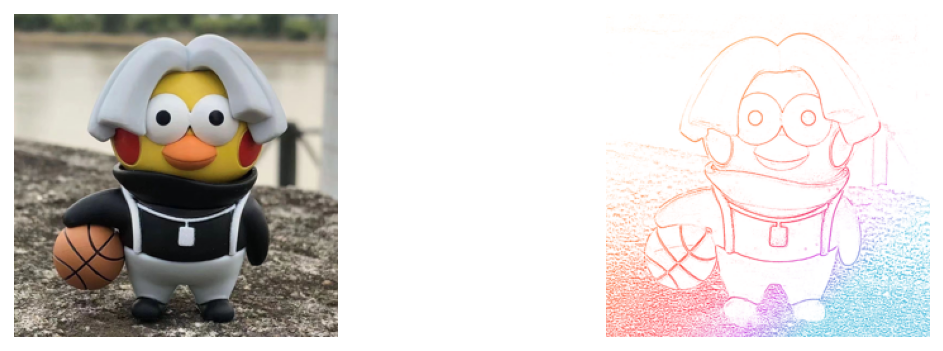

In [12]:
from mindspore import load_checkpoint, load_param_into_net, Tensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import mindspore.common.dtype as mstype


# 加载预训练的参数
ckpt_dir = 'results/'
param_g = load_checkpoint(ckpt_dir + "ckpt2Generator.ckpt")
load_param_into_net(net_generator, param_g)

# 将自定义图片转换为Tensor
def load_and_preprocess_custom_image(image_path):
    img = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
    img = img.resize((256, 256))  # 调整图像大小为模型输入大小
    img = np.array(img).astype(np.float32)
    img = img / 127.5 - 1  # 归一化到 [-1, 1]
    img = img.transpose(2, 0, 1)  # 转换为 (C, H, W)
    return img

# 定义一个函数来处理预测结果并显示
def show_prediction(input_tensor, predict_tensor):
    plt.figure(figsize=(10, 3), dpi=140)
    input_img = input_tensor[0].asnumpy().transpose(1, 2, 0)  # NCHW 到 HWC
    predict_img = predict_tensor[0].asnumpy().transpose(1, 2, 0)
    result_img = Image.open('result.png').convert('RGB')
    result_img = result_img.resize((256, 256))  # 调整图像大小为模型输入大小
    result_img = np.array(result_img).astype(np.float32)
    result_img = result_img / 127.5 - 1 
    # 显示原始图片
    plt.subplot(1, 2, 1)
    plt.imshow((input_img + 1) / 2)  # 归一化到 [0, 1]
    plt.axis("off")
    
    # 显示预测结果
    plt.subplot(1, 2, 2)
    plt.imshow((result_img + 1) / 2)  # 归一化到 [0, 1]
    plt.axis("off")
    
    plt.show()

# 使用自定义图片进行预测
image_path = 'origin.png'  # 替换为你的图片路径
custom_image = load_and_preprocess_custom_image(image_path)
custom_image = np.expand_dims(custom_image, axis=0)  # 添加 batch 维度
custom_image = Tensor(custom_image, mstype.float32)
custom_predict = net_generator(custom_image)
show_prediction(custom_image, custom_predict)

In [13]:
!pip install transformers torch

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 887.5 MB 71.4 MB/s eta 0:00:01    |██▌                             | 68.0 MB 69.4 MB/s eta 0:00:12                       | 86.0 MB 69.4 MB/s eta 0:00:12     |████▎                           | 118.7 MB 98.4 MB/s eta 0:00:08     |███████▋                        | 210.1 MB 88.1 MB/s eta 0:00:08��████▍                       | 234.0 MB 88.1 MB/s eta 0:00:08
     |████████████████████████████████| 317.1 MB 98.9 MB/s eta 0:00:011   |██████▉                         | 68.3 MB 23.3 MB/s eta 0:00:11     |██████████████████████████████▉ | 305.9 MB 120.1 MB/s eta 0:00:01
     |████████████████████████████████| 21.0 MB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 849 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 557.1 MB 95.2 MB/s eta 0:00:01    |████▌                           | 77.5 MB 69.9 MB/s eta 0:00:07     |███████                         | 120.8

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# 加载预训练的 GPT-2 模型和分词器
model_name = "gpt2"  # 您可以选择其他预训练模型，例如 "gpt2-medium", "gpt2-large", "gpt2-xl"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# 将模型设置为评估模式
model.eval()

# 定义生成文本的函数
def generate_text(prompt, max_length=50, top_p=0.9, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        top_p=top_p,
        temperature=temperature,
        do_sample=True
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# 示例调用
prompt = "Once upon a time"
generated_text = generate_text(prompt)
print(generated_text)

In [49]:
import gradio as gr

def predict(input, max_length, top_p, temperature):
    response = generate_text(input, max_length=max_length, top_p=top_p, temperature=temperature)
    return response

# 创建 Gradio 界面
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.inputs.Textbox(lines=2, placeholder="输入文本"),
        gr.inputs.Slider(0, 100, step=1, default=50, label="Maximum length"),
        gr.inputs.Slider(0, 1, step=0.01, default=0.9, label="Top P"),
        gr.inputs.Slider(0, 1, step=0.01, default=0.7, label="Temperature")
    ],
    outputs="text"
)

iface.launch()

/home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/gradio/inputs.py:28: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/gradio/inputs.py:37: UserWarning: `optional` parameter is deprecated, and it has no effect
  optional=optional,
/home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/gradio/inputs.py:37: UserWarning: `numeric` parameter is deprecated, and it has no effect
  optional=optional,
/home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/gradio/inputs.py:90: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs i

IMPORTANT: You are using gradio version 3.34.0, however version 4.29.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [50]:
import torch
from transformers import GPT2LMHeadModel, BertTokenizer

# 加载预训练的中文 GPT-2 模型和分词器
model_name = "uer/gpt2-chinese-cluecorpussmall"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# 将模型设置为评估模式
model.eval()

# 定义生成文本的函数
def generate_text(prompt, max_length=50, top_p=0.9, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        top_p=top_p,
        temperature=temperature,
        do_sample=True
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# 示例调用
prompt = "从前有一个小女孩"
generated_text = generate_text(prompt)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


从 前 有 一 个 小 女 孩 了 她 的 大 学 。 大 学 里 的 我 们 一 起 走 过 了 大 学 的 三 年 。 不 知 不 觉 我 们 都 在 成 长 。 买 了 她 的


In [69]:
import torch
from transformers import GPT2LMHeadModel, BertTokenizer, Trainer, TrainingArguments, GPT2Config
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import gradio as gr

# 加载预训练的中文 GPT-2 模型和分词器
model_name = "uer/gpt2-chinese-cluecorpussmall"
gpt2_model = GPT2LMHeadModel.from_pretrained(model_name)
gpt2_tokenizer = BertTokenizer.from_pretrained(model_name)

# 加载微调后的诗词生成模型
def load_poetry_model(mode="CCPC"):
    model_config = GPT2Config.from_json_file(f"./model_{mode}/config.json")
    model = GPT2LMHeadModel.from_pretrained(f"./model_{mode}/final_model")
    tokenizer = BertTokenizer(vocab_file=f"./model_{mode}/vocab.txt", do_lower_case=False)
    if mode == "CCPC":
        tokenizer.add_tokens("[SPACE]", special_tokens=True)
        tokenizer.add_tokens("[KEYWORD]", special_tokens=True)
        tokenizer.add_tokens("[CONTENT]", special_tokens=True)
    return model, tokenizer

poetry_model, poetry_tokenizer = load_poetry_model()

# 加载Pix2Pix模型
# 这里假设你已经有一个预训练的pix2pix模型
# net_generator = ...  # 定义你的 net_generator
# param_g = torch.load("path/to/your/pix2pix_model.pth")
# net_generator.load_state_dict(param_g)

# 将自定义图片转换为Tensor
def load_and_preprocess_custom_image(image_path, brightness=1.0, contrast=1.0):
    img = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
    img = img.resize((256, 256))  # 调整图像大小为模型输入大小
    
    # 调整亮度和对比度
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    
    img = np.array(img).astype(np.float32)
    img = img / 127.5 - 1  # 归一化到 [-1, 1]
    img = img.transpose(2, 0, 1)  # 转换为 (C, H, W)
    return img

# 定义一个函数来处理预测结果并显示
def show_and_save_prediction(input_tensor, predict_tensor, output_path):
    plt.figure(figsize=(10, 3), dpi=140)
    input_img = input_tensor[0].transpose(1, 2, 0)  # NCHW 到 HWC
    predict_img = predict_tensor[0].transpose(1, 2, 0)
    
    # 显示原始图片
    plt.subplot(1, 2, 1)
    plt.imshow((input_img + 1) / 2)  # 归一化到 [0, 1]
    plt.axis("off")
    
    # 显示预测结果
    plt.subplot(1, 2, 2)
    plt.imshow((predict_img + 1) / 2)  # 归一化到 [0, 1]
    plt.axis("off")
    
    plt.show()
    
    # 保存生成的图像
    output_img = Image.fromarray(((predict_img + 1) / 2 * 255).astype(np.uint8))
    output_img.save(output_path)
    print(f"生成的图像已保存到 {output_path}")

# 将文本中的字符转为网页上可以支持的字符，避免被误认为是HTML标签
def parse_text(text):
    """copy from https://github.com/GaiZhenbiao/ChuanhuChatGPT/"""
    lines = text.split("\n")
    lines = [line for line in lines if line != ""]
    count = 0
    for i, line in enumerate(lines):
        if "```" in line:
            count += 1
            items = line.split('`')
            if count % 2 == 1:
                lines[i] = f'<pre><code class="language-{items[-1]}">'
            else:
                lines[i] = f'<br></code></pre>'
        else:
            if i > 0:
                if count % 2 == 1:
                    line = line.replace("`", "\`")
                    line = line.replace("<", "&lt;")
                    line = line.replace(">", "&gt;")
                    line = line.replace(" ", "&nbsp;")
                    line = line.replace("*", "&ast;")
                    line = line.replace("_", "&lowbar;")
                    line = line.replace("-", "&#45;")
                    line = line.replace(".", "&#46;")
                    line = line.replace("!", "&#33;")
                    line = line.replace("(", "&#40;")
                    line = line.replace(")", "&#41;")
                    line = line.replace("$", "&#36;")
                lines[i] = "<br>"+line
    text = "".join(lines)
    return text

# 编写Gradio调用函数
def predict(input, chatbot, max_length, top_p, temperature, history):
    if input.startswith("动漫化"):
        # 提取图片路径
        image_path = input.split(" ")[1]
        output_path = "results/animated_image.jpg"
        
        # 进行图像转换
        custom_image = load_and_preprocess_custom_image(image_path)
        custom_image = np.expand_dims(custom_image, axis=0)  # 添加 batch 维度
        custom_image = torch.tensor(custom_image, dtype=torch.float32)
        custom_predict = net_generator(custom_image)
        show_and_save_prediction(custom_image.numpy(), custom_predict.detach().numpy(), output_path)
        
        response = f"图像已动漫化并保存到 {output_path}"
        chatbot.append((parse_text(input), parse_text(response)))
        yield chatbot, history
    elif input.startswith("生成诗词"):
        # 提取用户场景描述
        scene_description = input[len("生成诗词"):].strip()
        
        # 生成诗词
        inputs = poetry_tokenizer(scene_description, return_tensors="pt")
        inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
        outputs = poetry_model.generate(inputs.input_ids, max_length=max_length, top_p=top_p, temperature=temperature)
        response = poetry_tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        chatbot.append((parse_text(input), parse_text(response)))
        yield chatbot, history
    else:
        chatbot.append((parse_text(input), ""))
        response = gpt2_model.generate(
            gpt2_tokenizer(input, return_tensors="pt").input_ids,
            max_length=max_length,
            top_p=top_p,
            temperature=temperature,
            do_sample=True
        )
        response_text = gpt2_tokenizer.decode(response[0], skip_special_tokens=True)
        chatbot[-1] = (parse_text(input), parse_text(response_text))
        yield chatbot, history

# 去除输入框的内容
def reset_user_input():
    return gr.update(value='')

# 清除状态
def reset_state():
    return [], [], None

# 运行Gradio界面，运行成功后点击“Running on public URL”后的网页链接即可体验
with gr.Blocks() as demo:
    gr.HTML("""<h1 align="center">GPT-2 and Pix2Pix Integration</h1>""")

    chatbot = gr.Chatbot()
    with gr.Row():
        with gr.Column(scale=4):
            with gr.Column(scale=12):
                user_input = gr.Textbox(show_label=False, placeholder="Input...", lines=3)
            with gr.Column(min_width=32, scale=1):
                with gr.Row():
                    submitBtn = gr.Button("一键开聊", variant="primary")
                    emptyBtn = gr.Button("清除历史")
            with gr.Column(scale=1):
                max_length = gr.Slider(0, 4096, value=2048, step=1.0, label="Maximum length", interactive=True)
                top_p = gr.Slider(0, 1, value=0.7, step=0.01, label="Top P", interactive=True)
                temperature = gr.Slider(0, 1, value=0.95, step=0.01, label="Temperature", interactive=True)               

    history = gr.State([])

    submitBtn.click(predict, [user_input, chatbot, max_length, top_p, temperature, history], [chatbot, history],
                    show_progress=True)
    submitBtn.click(reset_user_input, [], [user_input])

    emptyBtn.click(reset_state, outputs=[chatbot, history], show_progress=True)

demo.queue().launch(server_port=7867, share=True)

Running on local URL:  http://127.0.0.1:7867

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app. 

Also please ensure that your antivirus or firewall is not blocking the binary file located at: /home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/gradio/frpc_linux_amd64_v0.2
